In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import re
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, ViTModel, AdamW
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.cuda.amp import GradScaler, autocast

In [4]:
folder_path = '/kaggle/input/caption-img-dataset/custom_captions_dataset/'
# Define paths to CSV files and image folders
train_csv_file = folder_path + 'train.csv'
train_img_folder = folder_path + 'train'
test_csv_file = folder_path + 'test.csv'
test_img_folder = folder_path + 'test'
val_csv_file = folder_path + 'val.csv'
val_img_folder = folder_path + 'val'

In [5]:
def get_preprocessed_caption(caption):
    caption = caption.replace('\s+', ' ')
    caption = caption.replace('[^A-Za-z]', '')
    caption = caption.strip().lower()
    caption = "<START> " + caption + " <END>"
    return caption

In [6]:
def load_caption(csv_file, img_folder):
    # Load CSV file
    data = pd.read_csv(csv_file)

    # Initialize lists to store image paths and corresponding captions
    captions = []
    img_dict = {}

    # Iterate over each row in the CSV file
    for index, row in data.iterrows():
        # Construct the image file path
        image_path = os.path.join(img_folder, row['filename'])
        image_name = image_path.split('/')[-1].split('.')[0]
        # Append the image path and caption to the lists
        caption = get_preprocessed_caption(row['caption'])
        captions.append(caption)
        img_dict[image_name] = caption

    return img_dict

In [7]:
import os
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomCaptionsDataset(Dataset):
    def __init__(self, root_dir, csv_file, preprocess_caption, transform=None):
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.preprocess_caption = preprocess_caption

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx, 1]))
        image = Image.open(img_name).convert('RGB')
        caption = self.preprocess_caption(self.data.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return image, caption

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a common size
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define paths to dataset files and folders
root_dir = "/kaggle/input/custom_captions_dataset/custom_captions_dataset/"
train_csv = os.path.join(root_dir, "train.csv")
test_csv = os.path.join(root_dir, "test.csv")
val_csv = os.path.join(root_dir, "val.csv")

In [8]:
train_folder = os.path.join(root_dir, "train")
test_folder = os.path.join(root_dir, "test")
val_folder = os.path.join(root_dir, "val")

# Create dataset instances
train_dataset = CustomCaptionsDataset(root_dir=train_folder, csv_file=train_csv, preprocess_caption=get_preprocessed_caption, transform=transform)
test_dataset = CustomCaptionsDataset(root_dir=test_folder, csv_file=test_csv, preprocess_caption=get_preprocessed_caption, transform=transform)
val_dataset = CustomCaptionsDataset(root_dir=val_folder, csv_file=val_csv, preprocess_caption=get_preprocessed_caption, transform=transform)

In [9]:
import os
os.listdir("/kaggle/input/custom_captions_dataset/custom_captions_dataset")

['val.csv', 'val', 'train.csv', 'test.csv', 'test', 'train']

In [10]:
# Tokenize captions
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens = {'bos_token': '<START>', 'eos_token': '<END>', 'pad_token': '<PAD>'}
tokenizer.add_special_tokens(special_tokens)

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)

    captions = list(captions)

    # Tokenize captions
    tokenized_captions = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
    input_ids = tokenized_captions['input_ids']
    attention_mask = tokenized_captions['attention_mask']

    # Return images, input_ids, and attention_mask for each batch
    return images, input_ids, attention_mask

# DataLoader
batch_size = 16
batch_test_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_test_size, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=4)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [11]:
from transformers import ViTModel, GPT2LMHeadModel, GPT2Config

class ViTEncoder(nn.Module):
    def __init__(self, pretrained_model_name="google/vit-base-patch16-224"):
        super(ViTEncoder, self).__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model_name)

    def forward(self, images):
        # Taking the [CLS] token's output for representing the whole image
        outputs = self.vit(pixel_values=images)
        return outputs.last_hidden_state[:, 0, :]

class GPT2Decoder(nn.Module):
    def __init__(self, encoder_dim, pretrained_model_name="gpt2"):
        super(GPT2Decoder, self).__init__()
        self.gpt2_config = GPT2Config.from_pretrained(pretrained_model_name)
        self.gpt2 = GPT2LMHeadModel.from_pretrained(pretrained_model_name, config=self.gpt2_config)

        # Adjust GPT2's embedding layer to take additional context from the image encoder
        # self.gpt2.resize_token_embeddings(self.gpt2_config.vocab_size + 1)  # For a special token
        self.gpt2.resize_token_embeddings(self.gpt2_config.vocab_size + 3)  # For a special token
        self.image_embedding = nn.Linear(encoder_dim, self.gpt2_config.n_embd)
        self.start_token = self.gpt2_config.vocab_size  # New start token ID

    def forward(self, encoder_hidden_states, input_ids, attention_mask=None):
        # Create an embedding for the [CLS] token's output from the encoder
        image_embeds = self.image_embedding(encoder_hidden_states).unsqueeze(1)  # Create image embeddings
        extended_input_ids = input_ids

        if attention_mask is not None:
            extended_attention_mask = torch.cat([torch.ones((attention_mask.size(0), 1), device=attention_mask.device, dtype=attention_mask.dtype), attention_mask], dim=1)
        else:
            extended_attention_mask = None # 1 + ATTAENT_MARK

        # Get embeddings for tokens (including the new start token for the image)
        inputs_embeds = self.gpt2.transformer.wte(extended_input_ids)
        # print("inputs_embeds =",inputs_embeds.shape)

        # Prepend image_embeds to the embeddings
        combined_embeds = torch.cat((image_embeds, inputs_embeds[:, :, :]), dim=1) # IMAGE + 1 + INPUT_ID + END


        outputs = self.gpt2(inputs_embeds=combined_embeds, attention_mask=extended_attention_mask)
        return outputs.logits

class ImageCaptioningModel(nn.Module):
    def __init__(self):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = ViTEncoder()
        encoder_dim = self.encoder.vit.config.hidden_size
        self.decoder = GPT2Decoder(encoder_dim=encoder_dim)

    def forward(self, images, input_ids, attention_mask=None):
        encoder_hidden_states = self.encoder(images)
        logits = self.decoder(encoder_hidden_states, input_ids, attention_mask)
        return logits


In [12]:
# Initialize Model
model = ImageCaptioningModel()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [13]:
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    model.to(device)
    total_loss = 0
    num_batch = 1

    scaler = GradScaler()

    for images, input_ids, attention_mask in dataloader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        max_length = input_ids.shape[1]
        batch_loss = 0
        batch_size = 0
        for i in range(2,max_length-1,50):
            with autocast():
                # Forward pass
                outputs = model(images, input_ids[:, :i], attention_mask[:, :i])
                # Adjust this line as necessary to match your model's specific output shape and logic
                outputs = outputs[:, :-1, :].contiguous()
                # Compute loss
                # Shift the input_ids to the right and ignore the index of pad_token_id in loss calculation
                loss = loss_fn(outputs.view(-1, outputs.size(-1)), input_ids[:, 1:i+1].reshape(-1))

            # Backward pass
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            batch_loss += loss.item()
            batch_size += 1
            
            torch.cuda.empty_cache()

        if num_batch%10 == 0:
            print(f'Batch {num_batch}, Loss : {batch_loss / batch_size}')
        total_loss += (batch_loss / batch_size)
        num_batch += 1


    average_loss = total_loss / len(dataloader)
    return average_loss



In [14]:
torch.cuda.empty_cache()

In [15]:
!pip install rouge
!pip install pycocoevalcap
from rouge import Rouge
from tqdm import tqdm
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
import csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 14.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 27.3 MB/s eta 0:00:00


In [16]:
def compute_cider_score(actual, predicted):
    cider_scorer = Cider()
    score , cider_scores = cider_scorer.compute_score(actual, predicted)
    return score # 1.2

def compute_spice_score(actual, predicted):
    spice_scorer = Spice()
    spice_score, _ = spice_scorer.compute_score(actual, predicted)
    return spice_score  # 0.4

def compute_rouge_l_score(actual, predicted):
    rouge = Rouge()
    scores = rouge.get_scores(predicted, actual, avg=True)
    return scores['rouge-l']['f']  # 0.4 - 0.5

In [20]:
import random

def evaluate_model(model, dataloader, device, tokenizer, max_length=60, num_samples=4):
    model.eval()  # Set the model to evaluation mode
    generated_captions = []
    actual_captions = []

    dataloader_iter = iter(dataloader)
    random_indices = random.sample(range(len(dataloader)), num_samples)
    
    with torch.no_grad():  # No need to track gradients
        for i in random_indices:
            images, cap, _ = next(dataloader_iter)
            images = images.to(device)
            
            input_ids = torch.full((images.size(0), 1), tokenizer.encode(tokenizer.bos_token)[0], dtype=torch.long).to(device)
            for _ in range(max_length):
                outputs = model(images, input_ids)
                predictions = outputs[:, -1, :].argmax(dim=-1, keepdim=True)
                input_ids = torch.cat((input_ids, predictions), dim=-1)
                if torch.all(predictions.squeeze(-1) == tokenizer.encode(tokenizer.eos_token)[0]):
                    break

            # Decode the generated ids to text
            for ids in input_ids:
                caption = tokenizer.decode(ids, skip_special_tokens=True)
                generated_captions.append(caption)
            
            for ids in cap:
                caption = tokenizer.decode(ids, skip_special_tokens=True)
                actual_captions.append(caption)

    return compute_rouge_l_score(actual_captions, generated_captions)


In [21]:
best_val_score = float('-inf')
best_model_path = 'best_model_t2.pickle'
optimizer = AdamW(model.parameters(), lr=5e-5)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [18]:

# Training the model
num_epochs = 25
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    print(f'Epoch {epoch+1}')
    avg_loss = train(model, train_dataloader, optimizer, loss_fn, device)
    
    val_score = evaluate_model(model, val_dataloader, device, tokenizer)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, val_score: {val_score:.4f}')

    # Save model if it has the best validation score so far
    if val_score > best_val_score:
        best_val_score = val_score
        with open("/kaggle/working/" + best_model_path, 'wb') as handle:
            pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Saved model with best validation score:", best_val_score)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


cuda


Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1
Batch 10, Loss : 0.17271028831601143
Batch 20, Loss : 0.012193165719509125
Batch 30, Loss : 0.23388616740703583
Batch 40, Loss : 0.14450186304748058
Batch 50, Loss : 0.1592047642916441
Batch 60, Loss : 0.18094966188073158
Batch 70, Loss : 0.16967248171567917
Batch 80, Loss : 0.22342389076948166
Batch 90, Loss : 0.23937155306339264
Batch 100, Loss : 0.22486315853893757
Batch 110, Loss : 0.20535860024392605
Batch 120, Loss : 0.30785192052523297
Batch 130, Loss : 0.2212502658367157
Batch 140, Loss : 0.19464237615466118
Batch 150, Loss : 0.18090114928781986
Batch 160, Loss : 0.023204084485769272
Batch 170, Loss : 0.18898814916610718
Batch 180, Loss : 0.10862237215042114
Batch 190, Loss : 0.18664853274822235
Batch 200, Loss : 0.08718161284923553
Batch 210, Loss : 0.23664478957653046
Batch 220, Loss : 0.15602009929716587
Batch 230, Loss : 0.22593283653259277
Batch 240, Loss : 0.27517101913690567
Batch 250, Loss : 0.2404712289571762
Batch 260, Loss : 0.23762761056423187
Batch 270, Los

Training Progress: 100%|██████████| 1/1 [04:55<00:00, 295.80s/it]

Saved model with best validation score: 0.31865944017966874


In [22]:
with open("/kaggle/working/" + 'model_t3_5.pickle', 'wb') as handle:
  pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open('/kaggle/input/best_model_t2.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [24]:
def generate_captions(model, dataloader, device, tokenizer, max_length=60):
    model.eval()  # Set the model to evaluation mode
    generated_captions = []

    with torch.no_grad():  # No need to track gradients
        for images, _, _ in dataloader:
#             print(images.shape)
            images = images.to(device)

            # Assuming the model has a method to extract features from images
            # and start the caption generation process.
            # This part is highly dependent on how your model is implemented.
            # Here is a generic approach:
            input_ids = torch.full((images.size(0), 1), tokenizer.encode(tokenizer.bos_token)[0], dtype=torch.long).to(device)
            for _ in range(max_length):
                outputs = model(images, input_ids)
                # Get the logits of the last predicted token
                predictions = outputs[:, -1, :].argmax(dim=-1, keepdim=True)
                # Concatenate the predicted token to the input_ids to use as input in the next step
                input_ids = torch.cat((input_ids, predictions), dim=-1)

                # Check if the last predicted token is the <END> token for all samples in the batch
                if torch.all(predictions.squeeze(-1) == tokenizer.encode(tokenizer.eos_token)[0]):
                    break

            # Decode the generated ids to text
            for ids in input_ids:
                caption = tokenizer.decode(ids, skip_special_tokens=True)
                generated_captions.append(caption)
                print(caption)
                # print('\n\n')
            break

    return generated_captions

# Usage:
generated_captions = generate_captions(model, test_dataloader, device, tokenizer)
# is busy vehicles parked the of building the looks it a city. building a with windows the is the building the is. are on street with cars buses there one which parked the way the. buses on street the and of are. lights on pole the

 different are buildings the on sides the have windows the glass are. are in with cars the is white red blue and bus. are on road also some and are by buildings the on side red have lamp in of and of. road a truck by buildings white a and car visible a truck a truck a


In [25]:
import torch.nn.functional as F

def beam_search(model, images, tokenizer, device, beam_width=5, max_length=60):
    # Initial token for each candidate sequence
    initial_input_ids = torch.full((images.size(0), 1), tokenizer.encode(tokenizer.bos_token)[0], dtype=torch.long).to(device)
    
    # Initialize beam candidates
    candidates = [(initial_input_ids, 0)]  # (sequence, log probability)

    # Beam search loop
    for _ in range(max_length):
        new_candidates = []

        for candidate_input_ids, log_prob in candidates:
            # Get the logits for the last predicted token
            outputs = model(images, candidate_input_ids)
            logits = outputs[:, -1, :]

            # Apply log_softmax to convert logits to log probabilities
            log_probs = F.log_softmax(logits, dim=-1)

            # Get the top K candidates for each sequence
            topk_probs, topk_indices = torch.topk(log_probs, beam_width, dim=-1)

            for i in range(beam_width):
                # Update the sequence with the new token
                new_input_ids = torch.cat((candidate_input_ids, topk_indices[:, i:i+1]), dim=-1)

                # Calculate the new log probability
                new_log_prob = log_prob + topk_probs[:, i].item()

                # Add the new candidate to the list
                new_candidates.append((new_input_ids, new_log_prob))

        # Select top K candidates based on their log probabilities
        new_candidates.sort(key=lambda x: x[1], reverse=True)
        candidates = new_candidates[:beam_width]

        # Check if all candidates have ended with the end token
        all_end_tokens = all(torch.all(candidate[0][:, -1] == tokenizer.encode(tokenizer.eos_token)[0]) for candidate in candidates)
        if all_end_tokens:
            break

    # Return the top candidate sequence
    top_sequence = candidates[0][0]
    return top_sequence


In [26]:
def generate_captions_beam_search(model, dataloader, device, tokenizer, beam_width=5, max_length=60):
    model.eval()  # Set the model to evaluation mode
    generated_captions = []
    count = 0

    # Truncate the file before writing new captions
    output_file_path = "/kaggle/working/" + "output_k1.csv"
    if os.path.exists(output_file_path):
        os.remove(output_file_path)

    with torch.no_grad():  # No need to track gradients
        for images, captions, _ in dataloader:
            images = images.to(device)

            # Apply beam search for caption generation
            top_sequence = beam_search(model, images, tokenizer, device, beam_width, max_length)

            # Decode the generated sequence
            for ids, cap in zip(top_sequence,captions):
                pred_caption = tokenizer.decode(ids, skip_special_tokens=True)
                original = tokenizer.decode(cap, skip_special_tokens=True)
#                 print("\noriginal caption - ", original)
#                 print("predicted caption - ", pred_caption)
                with open(output_file_path, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow([count, pred_caption, original])
                    count += 1
                generated_captions.append(pred_caption)
                if count % 10 == 0:
                    print(f"{count} image caption generation done")

    return generated_captions

# Usage:
beam_width = 3 
generated_captions_beam_search = generate_captions_beam_search(model, test_dataloader, device, tokenizer, beam_width)

10 image caption generation done
20 image caption generation done
30 image caption generation done
40 image caption generation done
50 image caption generation done
60 image caption generation done
70 image caption generation done
80 image caption generation done
90 image caption generation done
100 image caption generation done
110 image caption generation done
120 image caption generation done
130 image caption generation done
140 image caption generation done
150 image caption generation done
160 image caption generation done
170 image caption generation done
180 image caption generation done
190 image caption generation done
200 image caption generation done
210 image caption generation done
220 image caption generation done
230 image caption generation done
240 image caption generation done
250 image caption generation done
260 image caption generation done
270 image caption generation done
280 image caption generation done
290 image caption generation done
300 image caption gener

In [27]:
pred_caption = []  # List to store the loaded data
actual=[]

with open( "/kaggle/working/" + "output_k1.csv", mode='r', newline='') as file:
    reader = csv.reader(file)
    for idx, pred, original in reader:
        pred_caption.append(pred)
        actual.append(original)

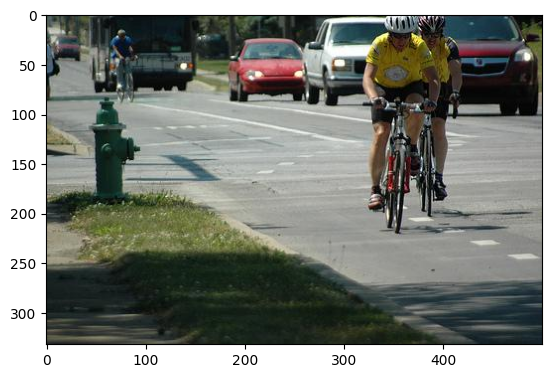

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
# test_mapping['test_2']
img_path=f'{root_dir}test/test_8.jpg'
image = Image.open(img_path)
plt.imshow(image)

In [29]:
pred_caption[7]

' people riding the are down street the are shirts. shirts. are. shirts. women wearing. are helmets the are. are in as lot cars the are in as lot. lines bikes be in as lot as cars the are in as. trees in as lot as. lines green the is as as'

In [30]:
actual[7]

' there are three men riding bicycles. two of the men are wearing yellow and the third man has a blue shirt. the two men are way ahead of the third man. the men are bicycling in the bicycle lane. the cars are on the left side of the men. '

In [31]:
rouge_l_score = compute_rouge_l_score(actual, pred_caption)
print(f"\nROUGE-L: {rouge_l_score}")


ROUGE-L: 0.3060691691828152


In [32]:
actual_dict, predicted_dict = {}, {}

for i in tqdm(range(len(actual))):  # Iterate through the first item for testing
    actual_dict[f"test_{i+1}.jpg"] = [actual[i]]  # Wrap ground truth captions in a list
    predicted_dict[f"test_{i+1}.jpg"] = [pred_caption[i]]  # Wrap the generated caption in a list

100%|██████████| 928/928 [00:00<00:00, 373650.20it/s]


In [33]:
cider_score = compute_cider_score(actual_dict, predicted_dict)
print(f"CIDEr: {cider_score}")

CIDEr: 0.03435318968165713


In [34]:
spice_score = compute_spice_score(actual_dict, predicted_dict)
print(f"SPICE: {spice_score}")

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classif

SPICE evaluation took: 5.559 min
SPICE: 0.08774878153608791


In [36]:
for key in actual_dict.keys():
    print("pic_id - ", key)
    print("original caption - ", actual_dict[key])
    print("predicted caption - ", predicted_dict[key])
    print("\n")

pic_id -  test_1.jpg
original caption -  [' a large building with bars on the windows in front of it. there is people walking in front of the building. there is a street in front of the building with many cars on it. ']
predicted caption -  [' different are buildings the of building the on right a and building the on left there a truck has windows the of building white color the on truck a van it black and with wheels the is color with wheels there a pole has signs yellow black white blue a and sign black white blue a a a a arrow']


pic_id -  test_2.jpg
original caption -  [' a person is skiing through the snow. there is loose snow all around them from him jumping. the person is wearing a yellow snow suit. the person is holding two ski poles in their hands. ']
predicted caption -  [' man snow down hill his covered in. goggles the is. goggles a liquid snow. man wearing snow is the. man the is a. is a wearing snow. is black white blue. is a in middle wearing snow. board covered snow in 